In [27]:
import os
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np

In [2]:
pwd

'/Users/user/Negi/DL/CNN'

In [3]:
affected_images=os.listdir("./cell_images/test/parasitized/")
unaffected_images=os.listdir("./cell_images/test/uninfected/")

In [5]:
affected_images[0]

'C118P79ThinF_IMG_20151002_105018_cell_150.png'

In [10]:
affected_Cell="./cell_images/test/parasitized/"+affected_images[0]
unaffected_cell="./cell_images/test/uninfected/"+unaffected_images[0]

In [35]:
affected_image=img.imread(affected_Cell)
unaffected_image=img.imread(unaffected_cell)

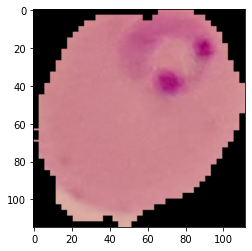

In [11]:
plt.imshow(img.imread(affected_Cell))

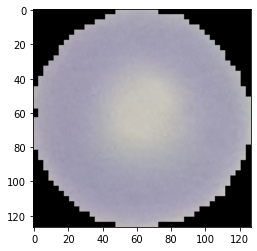

In [12]:
plt.imshow(img.imread(unaffected_cell))

In [17]:
d1=[]
d2=[]
for image_details in os.listdir("./cell_images/test/uninfected/"):
    image=img.imread('./cell_images/test/uninfected/'+image_details)
    d1.append(image.shape[0])
    d2.append(image.shape[1])

/Users/user/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


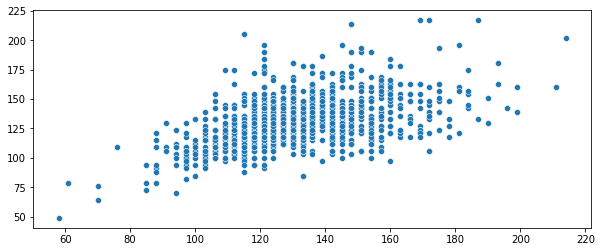

In [29]:
plt.figure(figsize=(10,4))
sbn.scatterplot(d1,d2);
#we have sifferent pixel size images , we have to make it same 

In [30]:
#we can make average 
print(np.mean(d1),np.mean(d2))

130.92538461538462 130.75


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [51]:
image_gen=ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             shear_range=0.2,
                             horizontal_flip=True,
                            fill_mode="nearest"
                            )

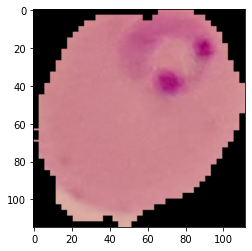

In [36]:
plt.imshow(affected_image)

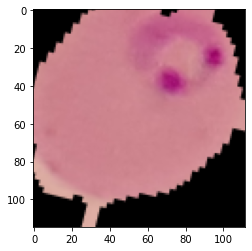

In [52]:
plt.imshow(image_gen.random_transform(affected_image))

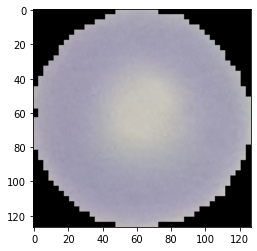

In [53]:
plt.imshow(unaffected_image)

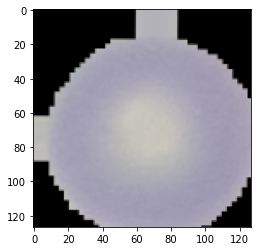

In [55]:
plt.imshow(image_gen.random_transform(unaffected_image))

In [62]:
image_gen.flow_from_directory("./cell_images/test/")

Found 2600 images belonging to 2 classes.


In [63]:
image_gen.flow_from_directory("./cell_images/train/")

Found 24958 images belonging to 2 classes.


In [64]:
os.listdir("./cell_images/test/")

['.DS_Store', 'parasitized', 'uninfected']

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report


In [69]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(130,130,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(4,4),input_shape=(130,130,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(4,4),input_shape=(130,130,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(132,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"],)

In [70]:
early=EarlyStopping(monitor="val_loss",patience=2);

In [71]:
batch_size=16

In [72]:
train_image_gen=image_gen.flow_from_directory("./cell_images/train/",
                                              target_size=(130,130),
                                              color_mode="rgb",
                                              class_mode="binary",
                                              batch_size=batch_size)

Found 24958 images belonging to 2 classes.


In [74]:
test_image_gen=image_gen.flow_from_directory("./cell_images/test/",
                                              target_size=(130,130),
                                              color_mode="rgb",
                                              class_mode="binary",
                                              batch_size=batch_size,
                                                 shuffle=False
                                            )

Found 2600 images belonging to 2 classes.


In [78]:
model.fit_generator(train_image_gen,epochs=15,callbacks=[early],validation_data=test_image_gen)

In [77]:
#lets load the model directly. because it will take to train
from tensorflow.keras.models import load_model

In [79]:
model=load_model("./malaria_detector.h5")

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [81]:
model.evaluate_generator(test_image_gen)

<ipython-input-81-31acfd80dad9>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_image_gen)


[35.670230865478516, 0.8692307472229004]

In [82]:
model.metrics_names

['loss', 'accuracy']

In [83]:
prediction=model.predict_generator(test_image_gen)

<ipython-input-83-3f2c194a7cb9>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction=model.predict_generator(test_image_gen)


In [85]:
prediction=prediction>0.5

In [86]:
prediction

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

In [89]:
confusion_matrix(test_image_gen.classes,prediction)

array([[1270,   30],
       [ 314,  986]])

In [90]:
print(classification_report(test_image_gen.classes,prediction))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1300
           1       0.97      0.76      0.85      1300

    accuracy                           0.87      2600
   macro avg       0.89      0.87      0.87      2600
weighted avg       0.89      0.87      0.87      2600



In [91]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [92]:
from tensorflow.keras.preprocessing import image

In [95]:
laoded_image=image.load_img("./cell_images/test/parasitized/"+affected_images[0])

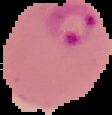

In [96]:
laoded_image

In [97]:
test_image_array=image.img_to_array(laoded_image)

In [99]:
test_image_array.shape

(115, 112, 3)

In [100]:
laoded_image=image.load_img("./cell_images/test/parasitized/"+affected_images[0],target_size=(130,130),color_mode="rgb")

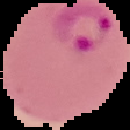

In [101]:
laoded_image

In [102]:
test_image_array=image.img_to_array(laoded_image)

In [103]:
test_image_array.shape

(130, 130, 3)

In [111]:
#aa=test_image_array.reshape(1,130,130,3) or 
dim_image=np.expand_dims(test_image_array,axis=0)

In [112]:
dim_image.shape

(1, 130, 130, 3)

In [113]:
model.predict(dim_image)

array([[0.]], dtype=float32)